In [ ]:
# %config InlineBackend.figure_format = 'svg' 


In [34]:
import scanpy as sc
from umap import UMAP

import pandas as pd
import numpy as np
import os, torch
import h5py
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white', format='svg')
sns.set_style("white")


scanpy==1.9.6 anndata==0.9.2 umap==0.5.4 numpy==1.24.4 scipy==1.10.1 pandas==1.5.0 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


下面代码是原始prototype、projection query特征进行umap

(25, 2048)
computing neighbors


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


TypeError: bad operand type for unary -: 'str'

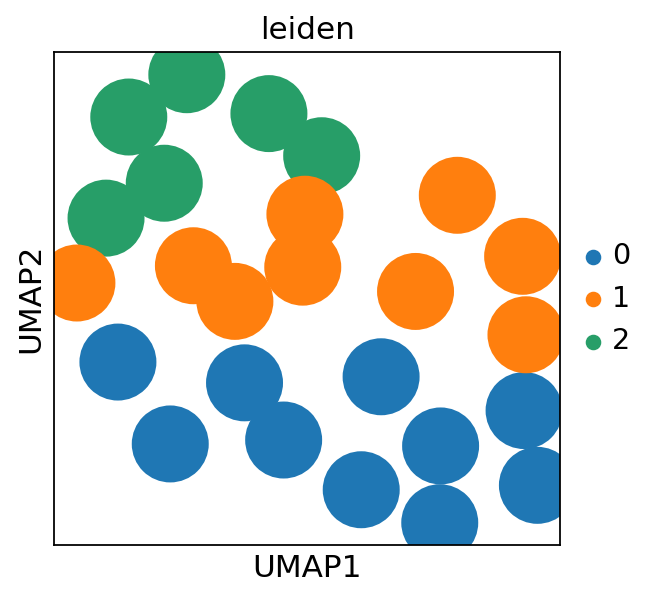

In [3]:
root_path = "/home/cyyan/Projects/HER2proj/models/HEROHE/HER2status"
# exp_name = "new_PhiTrans_sim_tile5ktwice500_selfqueryparam_uniform"
# exp_name = "new_PhiTrans_sim_tile5ktwice500_query_uniformx4"
exp_name = "new_PhiTrans_align_sim_tile5ktwice500"

# exp_name = "new_PhiTrans_align_sim_tile5ktwice500"
# exp_name = "new_ProtoMIL_sim_Cosine_mean_tile5ktwice500_0insteval"


for tidx in range(5):
    for kidx in range(1):
        filename = os.path.join(root_path, exp_name, f"time{tidx}", f"fold_{kidx}_prototypes_model_projection.pt")

        prototype_embedding = torch.load(filename)

        ori_pro_feat = prototype_embedding['global_cents_feats'].cpu().numpy()
        proj_pro_feat = prototype_embedding['projection_prototype'].cpu().numpy()
        query_pro_feat = prototype_embedding['query_prototype'].cpu().numpy()


        for key_ in prototype_embedding.keys():
            pro_feat = prototype_embedding[key_].cpu().numpy()
            print(pro_feat.shape)
            prototype_id_info = list(range(len(pro_feat)))
            prototype_id_info = [f"proid{idx}" for idx in prototype_id_info]

            prototype_feats_info = pd.DataFrame({'pro_id':prototype_id_info})

            adata = sc.AnnData(X=pro_feat, obs=prototype_feats_info)
        
            sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X')
            sc.tl.leiden(adata)

            sc.tl.paga(adata)
            sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

            sc.tl.umap(adata, init_pos='paga')
            sc.pl.umap(adata, color=['leiden', 'pro_id'])


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by

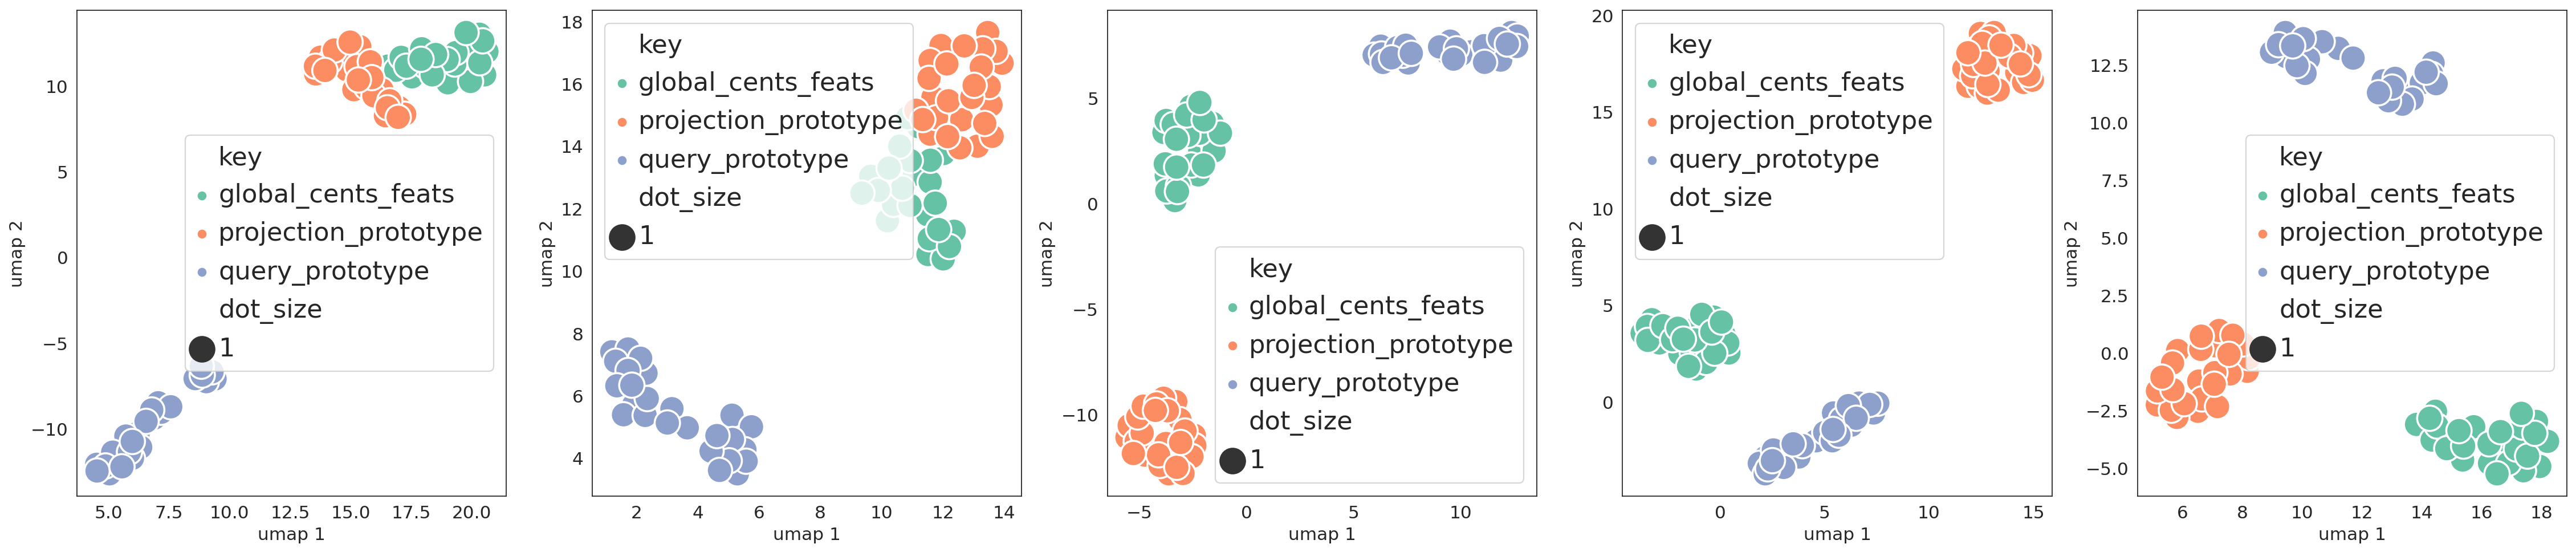

In [58]:
root_path = "/home/cyyan/Projects/HER2proj/models/HEROHE/HER2status"
# exp_name = "new_PhiTrans_sim_tile5ktwice500_selfqueryparam_uniform"
# exp_name = "new_PhiTrans_sim_tile5ktwice500_query_uniformx4"
exp_name = "new_PhiTrans_align_sim_tile5ktwice500"


umap_2d = UMAP(n_components=2, random_state=9000)


fig, ax =plt.subplots(1,5, figsize=(35, 7))

for tidx in range(5):
    for kidx in range(1):
        filename = os.path.join(root_path, exp_name, f"time{tidx}", f"fold_{kidx}_prototypes_model_projection.pt")

        prototype_embedding = torch.load(filename)

        ori_pro_feat = prototype_embedding['global_cents_feats'].cpu().numpy()
        proj_pro_feat = prototype_embedding['projection_prototype'].cpu().numpy()
        query_pro_feat = prototype_embedding['query_prototype'].cpu().numpy()


        time_fold_embedded_df = pd.DataFrame()
        for embed_idx, key_ in enumerate(prototype_embedding.keys()):
            pro_feat = prototype_embedding[key_].cpu().numpy()

            prototype_id_info = list(range(len(pro_feat)))
            prototype_id_info = [f"proid{idx}" for idx in prototype_id_info]


            projection_2d = umap_2d.fit_transform(pro_feat)

            X_embedded_df = pd.DataFrame(
                {
                    "dot_size": [1]*len(prototype_id_info),
                    "key": [key_]*len(prototype_id_info),
                    "pro_id":prototype_id_info,
                    "umap 1": projection_2d[:, :1].flatten(),
                    "umap 2": projection_2d[:, 1:2].flatten(),
                }
            )
            time_fold_embedded_df = pd.concat([time_fold_embedded_df, X_embedded_df], axis=0)

            # X_embedded_df = X_embedded_df.sample(frac=1)


        ############################ Create scatter plots
        sns.scatterplot(
            data=time_fold_embedded_df,
            x='umap 1', 
            y='umap 2',
            size='dot_size',
            sizes=(400, 400),
            hue='key',
            # hue_order=control_order,
            # palette="#0343ff",
            palette = 'Set2',
            alpha=1,
            ax=ax[tidx]
        )
        ax[tidx].legend(fontsize='x-large', facecolor="white")


# sns.despine()
# plt.tight_layout()
# plt.legend(labels=prototype_embedding.keys())
plt.savefig("/home/cyyan/Projects/HER2proj/post_results/embed_heatmap/prototypes_trans.svg", dpi=300)

AnnData object with n_obs × n_vars = 50 × 512
    obs: 'type', 'pro_id'
computing neighbors


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/cyyan/anaconda3/envs/torch20/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


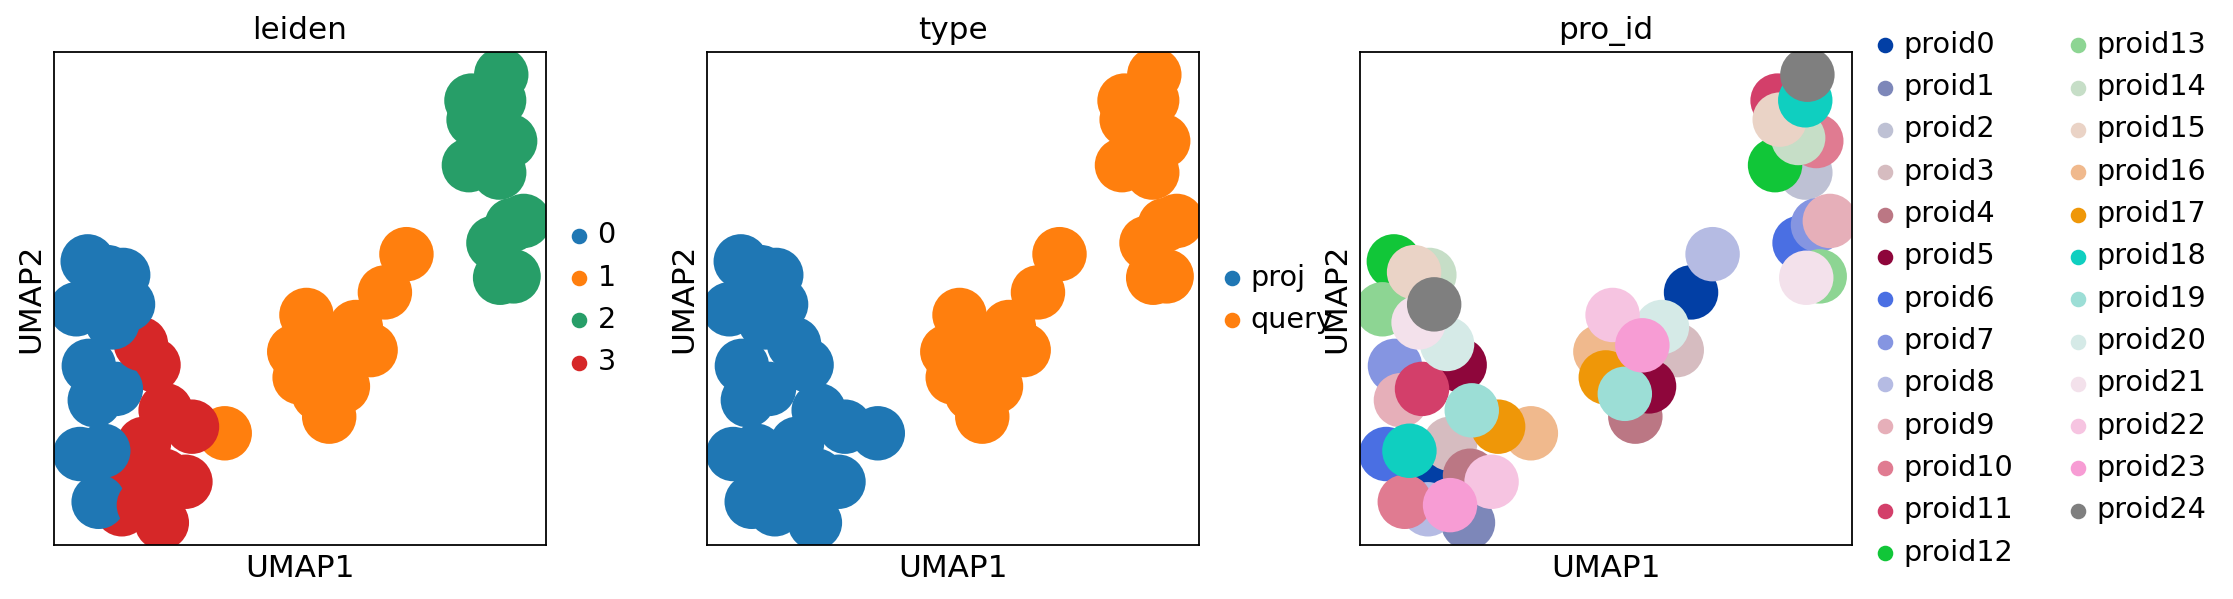

In [3]:
root_path = "/home/cyyan/Projects/HER2proj/models/HEROHE/HER2status"
# exp_name = "new_PhiTrans_sim_tile5ktwice500_selfqueryparam_uniform"
# exp_name = "new_PhiTrans_sim_tile5ktwice500_query_uniformx4"
exp_name = "new_PhiTrans_align_sim_tile5ktwice500"

# exp_name = "new_PhiTrans_align_sim_tile5ktwice500"
# exp_name = "new_ProtoMIL_sim_Cosine_mean_tile5ktwice500_0insteval"

# fig, ax =plt.subplots(1,3, figsize=(20, 5))

for tidx in range(5):
    for kidx in range(1):
        filename = os.path.join(root_path, exp_name, f"time{tidx}", f"fold_{kidx}_prototypes_model_projection.pt")

        prototype_embedding = torch.load(filename)

        ori_pro_feat = prototype_embedding['global_cents_feats'].cpu().numpy()
        proj_pro_feat = prototype_embedding['projection_prototype'].cpu().numpy()
        query_pro_feat = prototype_embedding['query_prototype'].cpu().numpy()

        prototype_feats = np.concatenate([proj_pro_feat, query_pro_feat], axis=0)
        prototype_feats.shape
        prototype_type_info = ["proj"]*len(proj_pro_feat) + ["query"]*len(query_pro_feat)

        prototype_id_info = list(range(len(proj_pro_feat))) + list(range(len(query_pro_feat)))
        prototype_id_info = [f"proid{idx}" for idx in prototype_id_info]

        prototype_feats_info = pd.DataFrame({'type': prototype_type_info, 'pro_id':prototype_id_info})
        prototype_feats_info


adata = sc.AnnData(X=prototype_feats, obs=prototype_feats_info)
# print(pd.Series(set_name, name="set_name"))
# adata.obs['w_coord', 'h_coord'] = pd.DataFrame(set_coords, columns=["w_coord", "h_coord"])
# adata.obs['slides_id'] = pd.DataFrame(slides_id, columns=['slides_id'])
# adata.obs = pd.DataFrame(test_tissue_type.astype(str), columns=["tissue type"])

# reserve_flag = [each in [0, 4] for each in test_tissue_type] 
# adata.obs['tumor flag'] = pd.DataFrame(np.array(reserve_flag).astype(str), columns=["tumor flag"])

# adata.obs = pd.DataFrame(slides_id, columns=['slides_id'])
print(adata)

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40, use_rep='X')
sc.tl.leiden(adata)

sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph

sc.tl.umap(adata, init_pos='paga')

sc.pl.umap(adata, color=['leiden', 'type', 'pro_id'])